In [ ]:
from importlib.metadata import version
version('gensim')

### Extract and Preprocess Text Data

In [1]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Import Dataset
df = pd.read_csv("data-bersihLDA-negatif.csv")
stop=set(stopwords.words("indonesian"))
stop_bow = set(stopwords.words("indonesian"))
stop_bow.discard("tidak")
factory = StemmerFactory()
stemmer = factory.create_stemmer()

text=df["tweet"]
cleaned_text_bow=[]
cleaned_text=[]
for line in text:
    tags = re.compile("^@[a-zA-Z_]*")
    line = re.sub(tags," ",line)
    hashtags = re.compile("#|\*")
    extraCharacters = re.compile("[^a-zA-Z]")
    line = re.sub(extraCharacters," ",line)

    filtered_words=[]
    filtered_words_bow=""
    for word in line.split():
        word=word.lower()
        if(word not in stop):
            word = stemmer.stem(word)
            filtered_words.append(word)
        if(word not in stop_bow):
            word = stemmer.stem(word)
            filtered_words_bow+=" "+word
    cleaned_text.append(filtered_words)
    cleaned_text_bow.append(filtered_words_bow)
            
data_bow = pd.DataFrame(data=cleaned_text_bow,columns=["tweet"])
data_bow["label"] = df["label"]
df["tweet"]=cleaned_text
print(df.head(10))
print()
print(data_bow.head(10))
print()


   Unnamed: 0                                              tweet    label
0           0  [juang, wujud, kampus, merdeka, desain, hasil,...  negatif
1           1  [wirausahawan, silah, magang, anggap, tambah, ...  negatif
2           2  [kampus, merdeka, kakak, semester, ambil, prod...  negatif
3           3  [kuliah, cek, informasi, informasi, kampus, sa...  negatif
4           4  [aktif, semester, ayo, ikut, kampus, ajar, aja...  negatif
5           5                    [sesal, pilih, kampus, merdeka]  negatif
6           6                             [iri, kampus, merdeka]  negatif
7           7  [jelang, skripsi, perintah, kampus, merdeka, m...  negatif
8           8  [mohon, banget, magang, program, kampus, merde...  negatif
9           9  [kampus, merdeka, perintah, sifat, disruptif, ...  negatif

                                               tweet    label
0   juang wujud kampus merdeka desain hasil daya ...  negatif
1   wirausahawan silah magang anggap bisnis biar ...  negatif

In [4]:
# Create Dictionary
id2word = corpora.Dictionary(df["tweet"])

# Create Corpus
texts = cleaned_text

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [7]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('daya', 1),
  ('desain', 1),
  ('era', 1),
  ('hasil', 1),
  ('juang', 1),
  ('kampus', 1),
  ('kualitas', 1),
  ('manusia', 1),
  ('merdeka', 1),
  ('wujud', 1)]]

In [8]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1, eta=0.1,
                                           per_word_topics=True)

In [9]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=cleaned_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.286004061558435

Coherence Score:  0.3770445732953177


In [10]:
lda_model.alpha

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32)

In [11]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.064*"kampus" + 0.062*"merdeka" + 0.053*"didik" + 0.023*"indonesia" + '
  '0.021*"menteri" + 0.018*"ringan" + 0.017*"tertawa" + 0.017*"dunia" + '
  '0.017*"harap" + 0.016*"gagas"'),
 (1,
  '0.069*"merana" + 0.042*"alas" + 0.039*"tugas" + 0.030*"mahasiswa" + '
  '0.030*"bikin" + 0.029*"usaha" + 0.026*"saran" + 0.024*"maksud" + '
  '0.021*"kuliah" + 0.019*"teman"'),
 (2,
  '0.149*"merdeka" + 0.130*"kampus" + 0.097*"bijak" + 0.061*"mahasiswa" + '
  '0.025*"tua" + 0.022*"sengsara" + 0.021*"suka" + 0.018*"ajar" + '
  '0.016*"pikir" + 0.012*"gara"'),
 (3,
  '0.160*"merdeka" + 0.139*"kampus" + 0.038*"keren" + 0.027*"turun" + '
  '0.023*"saku" + 0.023*"banget" + 0.020*"magang" + 0.017*"ajar" + '
  '0.017*"ikut" + 0.015*"demo"'),
 (4,
  '0.120*"merdeka" + 0.119*"kampus" + 0.051*"magang" + 0.034*"mahasiswa" + '
  '0.028*"banget" + 0.022*"daring" + 0.019*"bayar" + 0.018*"sih" + '
  '0.016*"seru" + 0.015*"anjing"'),
 (5,
  '0.103*"kampus" + 0.103*"merdeka" + 0.041*"banget" + 0.040*"magang

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

c:\Users\HP\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.149525  0.003097       1        1  22.459687
5     -0.116367  0.071835       2        1  20.320210
3     -0.148948  0.081707       3        1  16.613860
6     -0.056600 -0.182272       4        1  12.911804
2     -0.097001 -0.104001       5        1   9.684653
0     -0.000111  0.140716       6        1   8.260277
7      0.297536  0.135981       7        1   5.648119
1      0.271016 -0.147061       8        1   4.101389, topic_info=          Term         Freq        Total Category  logprob  loglift
17   mahasiswa   269.000000   269.000000  Default  30.0000  30.0000
200      bijak    93.000000    93.000000  Default  29.0000  29.0000
8      merdeka  1047.000000  1047.000000  Default  28.0000  28.0000
5       kampus   997.000000   997.000000  Default  27.0000  27.0000
952      ribet    44.000000    44.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
534      henti     2.023185     2.629991   Topic8  -5.2930   2.9315
90       bikin    11.969222    15.734076   Topic8  -3.5154   2.9204
86       usaha    11.844797    35.182067   Topic8  -3.5258   2.1052
41      kuliah     8.633623    81.954524   Topic8  -3.8421   0.9433
17   mahasiswa    12.102221   269.801148   Topic8  -3.5043   0.0895

[351 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
205       5  0.881358     ada
506       1  0.984861    aduh
1581      4  0.952794    ajak
46        2  0.391774    ajar
46        3  0.274242    ajar
...     ...       ...     ...
86        8  0.341083   usaha
397       6  0.981913  vokasi
289       5  0.948224  wacana
269       1  0.979525   wajib
330       6  0.842028     wow

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 4, 7, 3, 1, 8, 2])

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1, eta=0.1,
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=cleaned_text, start=2, limit=100, step=3)

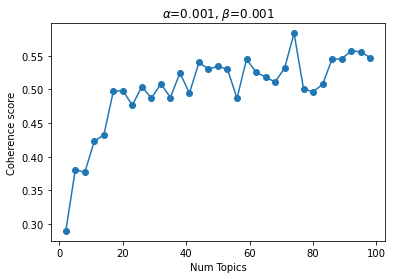

In [15]:
# Show graph
limit=100; start=2; step=3;
x = range(start, limit, step)
eq = r"$\alpha$=0.001, $\beta$=0.001"
plt.title(eq) 
plt.plot(x, coherence_values, '-o')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [16]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 5))

Num Topics = 2  has Coherence Value of 0.2897
Num Topics = 5  has Coherence Value of 0.38062
Num Topics = 8  has Coherence Value of 0.37704
Num Topics = 11  has Coherence Value of 0.42299
Num Topics = 14  has Coherence Value of 0.43241
Num Topics = 17  has Coherence Value of 0.4974
Num Topics = 20  has Coherence Value of 0.49801
Num Topics = 23  has Coherence Value of 0.47662
Num Topics = 26  has Coherence Value of 0.50437
Num Topics = 29  has Coherence Value of 0.487
Num Topics = 32  has Coherence Value of 0.50839
Num Topics = 35  has Coherence Value of 0.48792
Num Topics = 38  has Coherence Value of 0.5247
Num Topics = 41  has Coherence Value of 0.49446
Num Topics = 44  has Coherence Value of 0.54009
Num Topics = 47  has Coherence Value of 0.53035
Num Topics = 50  has Coherence Value of 0.53436
Num Topics = 53  has Coherence Value of 0.52997
Num Topics = 56  has Coherence Value of 0.48681
Num Topics = 59  has Coherence Value of 0.54463
Num Topics = 62  has Coherence Value of 0.52598


In [17]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.139*"merdeka" + 0.130*"kampus" + 0.084*"mahasiswa" + 0.042*"bijak" + '
  '0.033*"sengsara" + 0.026*"ukt" + 0.015*"merana" + 0.013*"kuliah" + '
  '0.013*"ajar" + 0.011*"kurikulum"'),
 (1,
  '0.120*"merdeka" + 0.110*"kampus" + 0.044*"mahasiswa" + 0.031*"magang" + '
  '0.021*"tertawa" + 0.016*"bebas" + 0.016*"usaha" + 0.015*"banget" + '
  '0.013*"anjing" + 0.013*"dosen"'),
 (2,
  '0.043*"bayar" + 0.032*"mas" + 0.024*"susah" + 0.019*"menteri" + '
  '0.018*"penuh" + 0.016*"biaya" + 0.016*"milenial" + 0.016*"gara" + '
  '0.014*"ngomong" + 0.013*"saku"'),
 (3,
  '0.140*"merdeka" + 0.129*"kampus" + 0.043*"banget" + 0.035*"magang" + '
  '0.033*"keren" + 0.023*"turun" + 0.017*"ajar" + 0.014*"saku" + 0.013*"ikut" '
  '+ 0.013*"demo"'),
 (4,
  '0.080*"kampus" + 0.076*"merdeka" + 0.034*"semester" + 0.030*"uang" + '
  '0.026*"magang" + 0.024*"kuliah" + 0.024*"ribet" + 0.019*"daring" + '
  '0.018*"banget" + 0.015*"ayo"')]


In [18]:
optimal_model.alpha

array([0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32)

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

c:\Users\HP\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.086050  0.179622       1        1  26.339576
3     -0.088787  0.073806       2        1  24.016125
1     -0.100750 -0.021922       3        1  21.512949
0     -0.091777 -0.228356       4        1  19.878453
2      0.367365 -0.003149       5        1   8.252898, topic_info=           Term         Freq        Total Category  logprob  loglift
17    mahasiswa   281.000000   281.000000  Default  30.0000  30.0000
200       bijak    83.000000    83.000000  Default  29.0000  29.0000
8       merdeka  1053.000000  1053.000000  Default  28.0000  28.0000
31     semester    88.000000    88.000000  Default  27.0000  27.0000
1146   sengsara    65.000000    65.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
560        saku    10.883540    43.012754   Topic5  -4.3097   1.1204
46         ajar     7.631064   103.512797   Topic5  -4.6647  -0.1129
514       bodoh     5.835521    19.425252   Topic5  -4.9330   1.2920
267         sks     5.669239    25.984636   Topic5  -4.9619   0.9722
5        kampus     6.378334  1002.647012   Topic5  -4.8441  -2.5629

[242 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
506       1  0.983732    aduh
46        1  0.251177    ajar
46        2  0.376765    ajar
46        3  0.057964    ajar
46        4  0.241516    ajar
...     ...       ...     ...
595       1  0.976743    urus
86        3  0.995248   usaha
397       4  0.959829  vokasi
269       1  0.975395   wajib
145       5  0.998415   wakil

[245 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])